In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import geopandas

from arcgis.geocoding import reverse_geocode
from arcgis.geometry import Geometry
from arcgis.gis import GIS

this is _switch_path ---- path =  C:\Users\morga\OneDrive\Documents\20_Galvanize\12_capstone\Supervised-ML\chi-traffic-accidents
this is _switch_path ---- path =  C:\Users\morga\Anaconda3\python37.zip
this is _switch_path ---- path =  C:\Users\morga\Anaconda3\DLLs
this is _switch_path ---- path =  C:\Users\morga\Anaconda3\lib
this is _switch_path ---- path =  C:\Users\morga\Anaconda3
this is _switch_path ---- path =  
this is _switch_path ---- path =  C:\Users\morga\Anaconda3\lib\site-packages


In [68]:
## User-Defined Functions

def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

## Traffic Crashes

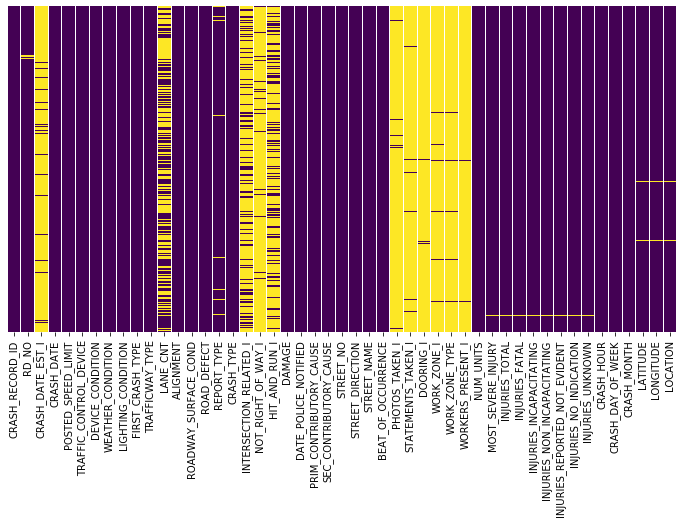

In [36]:
crashes = pd.read_csv('data/traffic_crashes.csv')
plt.figure(figsize=(12,6))
sns.heatmap(crashes.isnull(), yticklabels=False, cbar=False, cmap='viridis');

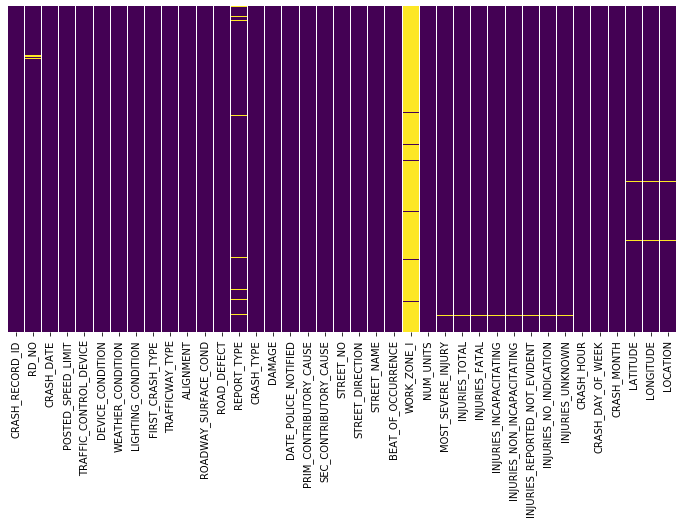

In [39]:
# DROP FEATUES THAT ARE PREDOMINANTLY COMPRISED OF NULL VALUES.
crashes2 = crashes.drop(['CRASH_DATE_EST_I', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I',
                         'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'LANE_CNT', 'WORK_ZONE_TYPE',
                         'WORKERS_PRESENT_I'], axis=1)
plt.figure(figsize=(12,6))
sns.heatmap(crashes2.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [40]:
crashes2['crash_date_2'] = pd.to_datetime(crashes2['CRASH_DATE'])
crashes2['crash_year'] = crashes2['crash_date_2'].dt.year

In [41]:
crashes3 = crashes2[(crashes2['crash_year'] == 2018) | (crashes2['crash_year'] == 2019)].copy()
crashes3 = crashes3[(crashes3['LATITUDE'].notnull()) & (crashes3['LONGITUDE'].notnull())].copy()
crashes3 = crashes3[(crashes3['LATITUDE'] != 0) & (crashes3['LONGITUDE'] != 0)]
crashes3.describe()

,POSTED_SPEED_LIMIT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,crash_year
count,234143.000000,234143.000000,234143.000000,232666.000000,232129.000000,232129.000000,232129.000000,232129.000000,232129.000000,232129.000000,232129.0,234143.000000,234143.000000,234143.000000,234143.000000,234143.000000,234143.000000
mean,28.350431,3603.558898,1265.566530,2.021782,0.185664,0.000965,0.020105,0.104407,0.060186,2.011998,0.0,13.114866,4.106973,6.562964,41.862438,-87.679640,2018.496641
std,6.295095,2808.349817,706.401979,0.445695,0.553877,0.033838,0.165098,0.415204,0.309629,1.183737,0.0,5.520527,1.970384,3.391075,0.085413,0.058682,0.499990
min,0.000000,1.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,41.644670,-87.934014,2018.000000
25%,30.000000,1213.000000,731.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,4.000000,41.791956,-87.721643,2018.000000
50%,30.000000,3125.000000,1222.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.879429,-87.674370,2018.000000
75%,30.000000,5498.000000,1831.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,9.000000,41.928039,-87.634531,2019.000000
max,70.000000,13799.000000,2535.000000,18.000000,21.000000,3.000000,7.000000,21.000000,10.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,-87.524587,2019.000000


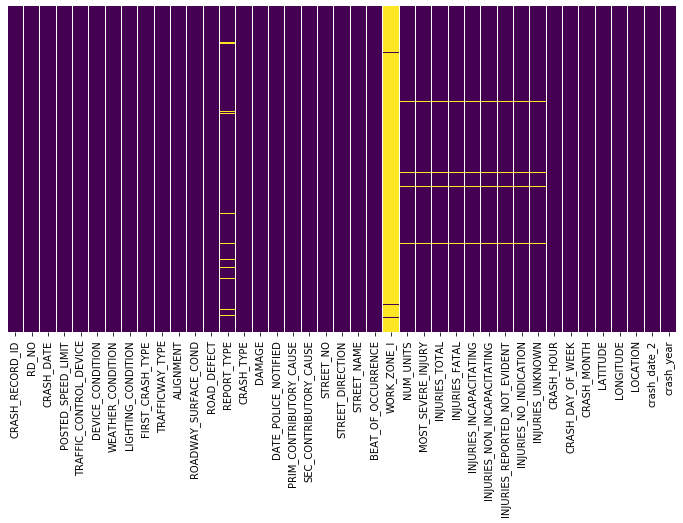

In [42]:
plt.figure(figsize=(12,6))
sns.heatmap(crashes3.isnull(), yticklabels=False, cbar=False, cmap='viridis');

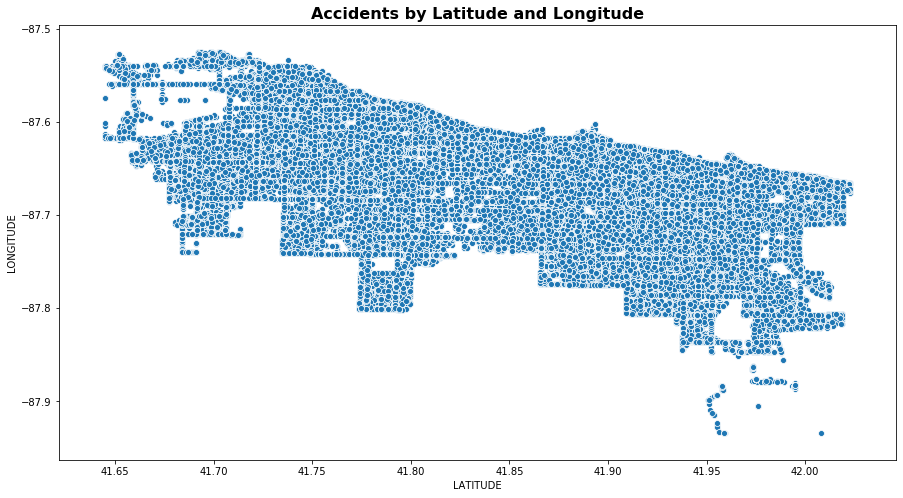

In [43]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='LATITUDE', y='LONGITUDE', data=crashes3)
plt.title('Accidents by Latitude and Longitude', fontsize=16, fontweight='bold');

In [78]:
crashes4 = crashes3[["CRASH_RECORD_ID", "crash_date_2", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "crash_year",
                    "POSTED_SPEED_LIMIT", "TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION", 
                    "TRAFFICWAY_TYPE", "ALIGNMENT", "ROADWAY_SURFACE_COND", "ROAD_DEFECT", 
                     "STREET_NO", "STREET_DIRECTION", "WORK_ZONE_I",
                    "LATITUDE", "LONGITUDE", "LOCATION"]].copy()
crashes4['lat_2'] = crashes4['LATITUDE'].apply(lambda x: truncate(x, 6)).astype(str) 
crashes4['long_2'] = crashes4['LONGITUDE'].apply(lambda x: truncate(x, 5)).astype(str)
crashes4['zip_join'] = crashes4['lat_2'] + crashes4['long_2']
crashes4.head()

,CRASH_RECORD_ID,crash_date_2,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,crash_year,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,...,ROAD_DEFECT,STREET_NO,STREET_DIRECTION,WORK_ZONE_I,LATITUDE,LONGITUDE,LOCATION,lat_2,long_2,zip_join
0,00027e2894dd2f3fe4ff320a6d332d18e465b5c8ba2e79...,2019-03-27 16:20:00,16,4,3,2019,30,NO CONTROLS,NO CONTROLS,CLEAR,...,NO DEFECTS,6223,N,NaN,41.994704,-87.699395,POINT (-87.699395085278 41.994703544264),41.994703,-87.69939,41.994703-87.69939
1,0002fb938eb0feaea33820fa55b71e4ea0b332125e1510...,2018-03-06 15:00:00,15,3,3,2018,30,NO CONTROLS,NO CONTROLS,CLEAR,...,NO DEFECTS,3600,W,NaN,41.904671,-87.716685,POINT (-87.716685434641 41.904671135876),41.904671,-87.71668,41.904671-87.71668
4,0006882952e53c291df267014a03b57684383e9ad66d9e...,2019-10-04 12:00:00,12,6,10,2019,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,...,NO DEFECTS,2401,S,NaN,41.848490,-87.675599,POINT (-87.67559940405 41.848490427751),41.84849,-87.67559,41.84849-87.67559
6,000dc02596041f0d23b030e424516c01221f2f8d6e856b...,2019-08-17 02:00:00,2,7,8,2019,30,NO CONTROLS,NO CONTROLS,CLEAR,...,UNKNOWN,4500,S,NaN,41.811379,-87.728756,POINT (-87.728755676298 41.811379220467),41.811379,-87.72875,41.811379-87.72875
8,00103edc70864a510d2ae8bf1855a49a6047a215543df9...,2018-03-16 12:25:00,12,6,3,2018,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,...,NO DEFECTS,430,N,NaN,41.890078,-87.647756,POINT (-87.647756089786 41.89007789797),41.890077,-87.64775,41.890077-87.64775


In [83]:
zip_code = pd.read_csv('data/chicago-zipcode.csv', sep=';')
zip_code['zip_join_2'] = zip_code['Latitude'].astype(str) + zip_code['Longitude'].astype(str)

In [86]:
zip_code.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint,zip_join_2
0,60651,Chicago,IL,41.901485,-87.74055,-6,1,"41.901485,-87.74055",41.901485-87.74055
1,60697,Chicago,IL,41.811929,-87.68732,-6,1,"41.811929,-87.68732",41.811929-87.68732
2,60667,Chicago,IL,41.811929,-87.68732,-6,1,"41.811929,-87.68732",41.811929-87.68732
3,60694,Chicago,IL,41.811929,-87.68732,-6,1,"41.811929,-87.68732",41.811929-87.68732
4,60684,Chicago,IL,41.811929,-87.68732,-6,1,"41.811929,-87.68732",41.811929-87.68732


In [85]:
accidents_zip = pd.merge(left=crashes4, right=zip_code, how='left', left_on='zip_join', right_on='zip_join_2')
accidents_zip.drop(['City', 'State', 'Latitude', 'Longitude', 'Timezone','Daylight savings time flag', 'geopoint'],
                  axis=1, inplace=True)
accidents_zip.head()

,CRASH_RECORD_ID,crash_date_2,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,crash_year,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,...,STREET_DIRECTION,WORK_ZONE_I,LATITUDE,LONGITUDE,LOCATION,lat_2,long_2,zip_join,Zip,zip_join_2
0,00027e2894dd2f3fe4ff320a6d332d18e465b5c8ba2e79...,2019-03-27 16:20:00,16,4,3,2019,30,NO CONTROLS,NO CONTROLS,CLEAR,...,N,NaN,41.994704,-87.699395,POINT (-87.699395085278 41.994703544264),41.994703,-87.69939,41.994703-87.69939,NaN,NaN
1,0002fb938eb0feaea33820fa55b71e4ea0b332125e1510...,2018-03-06 15:00:00,15,3,3,2018,30,NO CONTROLS,NO CONTROLS,CLEAR,...,W,NaN,41.904671,-87.716685,POINT (-87.716685434641 41.904671135876),41.904671,-87.71668,41.904671-87.71668,NaN,NaN
2,0006882952e53c291df267014a03b57684383e9ad66d9e...,2019-10-04 12:00:00,12,6,10,2019,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,...,S,NaN,41.848490,-87.675599,POINT (-87.67559940405 41.848490427751),41.84849,-87.67559,41.84849-87.67559,NaN,NaN
3,000dc02596041f0d23b030e424516c01221f2f8d6e856b...,2019-08-17 02:00:00,2,7,8,2019,30,NO CONTROLS,NO CONTROLS,CLEAR,...,S,NaN,41.811379,-87.728756,POINT (-87.728755676298 41.811379220467),41.811379,-87.72875,41.811379-87.72875,NaN,NaN
4,00103edc70864a510d2ae8bf1855a49a6047a215543df9...,2018-03-16 12:25:00,12,6,3,2018,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,...,N,NaN,41.890078,-87.647756,POINT (-87.647756089786 41.89007789797),41.890077,-87.64775,41.890077-87.64775,NaN,NaN


---
## Traffic Congestion

In [54]:
congest_13_18 = pd.read_csv('data/traffic_congest_2011-2018.csv')
congest_13_18.head()

,TIME,SEGMENTID,BUS COUNT,MESSAGE COUNT,SPEED
0,01/16/2013 11:50:32 PM,116,2.0,7.0,18
1,02/24/2013 11:50:32 PM,54,2.0,11.0,23
2,02/17/2013 11:50:32 PM,597,0.0,0.0,-1
3,02/23/2013 11:50:32 PM,363,1.0,4.0,25
4,12/01/2014 11:50:32 PM,203,0.0,0.0,-1


In [11]:
congest_13_18['date_time'] = pd.to_datetime(congest_13_18['TIME'])
congest_13_18['year'] = congest_13_18['date_time'].dt.year
congest_13_18.drop('TIME', axis=1, inplace=True)
congest_18 = congest_13_18[congest_13_18['year'] == 2018].copy()
congest_18.head(2)

,SEGMENTID,BUS COUNT,MESSAGE COUNT,SPEED,date_time,year
12163281,1307,2.0,13.0,10,2018-04-27 16:51:07,2018
12163282,1305,3.0,10.0,25,2018-04-27 16:51:07,2018


In [12]:
congest_13_18['date_time'].min()

Timestamp('2011-08-02 23:50:32')

In [31]:
print("Last date: ", congest_18['date_time'].max())
print("First date: ", congest_18['date_time'].min())

Last date:  2018-05-03 12:01:31
First date:  2018-03-13 09:30:55


In [18]:
congest_curr = pd.read_csv('data/traffic_congest_2018-Current.csv', nrows=50000)
congest_curr.describe()

,SEGMENT_ID,SPEED,LENGTH,BUS_COUNT,MESSAGE_COUNT,HOUR,DAY_OF_WEEK,MONTH,START_LATITUDE,START_LONGITUDE,END_LATITUDE,END_LONGITUDE
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,595.438260,17.339100,0.527260,1.084100,8.511920,14.298020,1.325460,1.650440,41.849938,-87.680696,41.850003,-87.680703
std,379.724416,13.561458,0.181971,1.194059,10.535337,4.023069,0.469063,0.936923,0.085624,0.058675,0.085661,0.058687
min,1.000000,-1.000000,0.070000,0.000000,0.000000,9.000000,1.000000,1.000000,41.658970,-87.836765,41.659006,-87.836834
25%,271.000000,-1.000000,0.500000,0.000000,0.000000,11.000000,1.000000,1.000000,41.785936,-87.724854,41.785936,-87.724841
50%,549.000000,21.000000,0.500000,1.000000,7.000000,13.000000,1.000000,1.000000,41.859912,-87.669074,41.859912,-87.669050
75%,890.000000,27.000000,0.530000,1.000000,13.000000,19.000000,2.000000,3.000000,41.910629,-87.635627,41.910629,-87.635260
max,1309.000000,65.000000,1.540000,18.000000,272.000000,21.000000,3.000000,3.000000,42.012831,-87.535052,42.012829,-87.535052


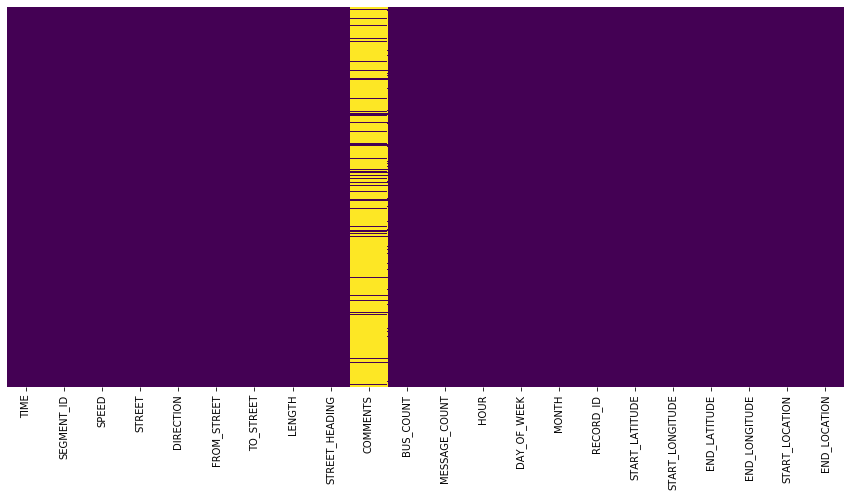

In [19]:
# Drop comments
plt.figure(figsize=(15,7))
sns.heatmap(congest_curr.isnull(), yticklabels=False, cbar=False, cmap='viridis')

---
## WEATHER

#### Feature Explanations:
- DAPR - Number of days included in the multiday precipitation total (MDPR)
- SNOW - Snowfall
- PRCP - Precipitation
- TOBS - Temperature at the time of observation
- SNWD - Snow depth
- TMAX - Maximum temperature
- TAVG - Average Temperature.
- TMIN - Minimum temperature
- MDPR - Multiday precipitation total (use with DAPR and DWPR, if available)
- WT01 - Fog, ice fog, or freezing fog (may include heavy fog)
- WT02 - Heavy fog or heaving freezing fog (not always distinguished from fog)
- WT03 - Thunder
- WT04 - Ice pellets, sleet, snow pellets, or small hail"
- WT05 - Hail (may include small hail)
- WT06 - Glaze or rime
- WT08 - Smoke or haze
- WT09 - Blowing or drifting snow
- WT11 - High or damaging winds


In [36]:
noaa = pd.read_csv('data/noaa.csv')
noaa['date_time'] = pd.to_datetime(noaa['DATE'])
noaa['year'] = noaa['date_time'].dt.year
noaa = noaa[(noaa['year'] == 2018) | (noaa['year'] == 2019)]
noaa.head(2)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,DAPR_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,...,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES,WT09,WT09_ATTRIBUTES,WT11,WT11_ATTRIBUTES,date_time,year
88,US1ILDP0098,"DOWNERS GROVE 0.9 S, IL US",41.784019,-88.016753,229.5,2018-03-28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-28,2018
89,US1ILDP0098,"DOWNERS GROVE 0.9 S, IL US",41.784019,-88.016753,229.5,2018-03-29,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-29,2018


In [37]:
noaa.drop('DATE', axis=1, inplace=True)

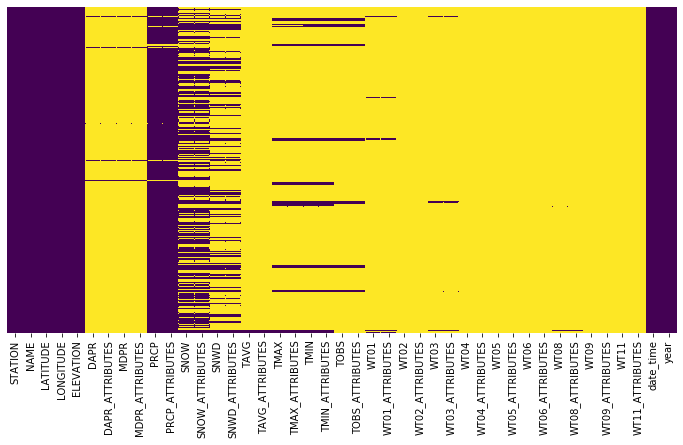

In [38]:
# Drop DAPR_ATTRIBUTE, DAPR, MDPR, MDPR_ATTRIBUTES
plt.figure(figsize=(12,6))
sns.heatmap(noaa.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [19]:
noaa.describe()

,LATITUDE,LONGITUDE,ELEVATION,DAPR,MDPR,PRCP,SNOW,SNWD,TAVG,TMAX,...,TOBS,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
count,106225.000000,106225.000000,106225.000000,1728.000000,1716.000000,103283.000000,62186.000000,28637.000000,978.000000,9333.000000,...,6407.000000,1235.0,43.0,476.0,46.0,14.0,87.0,369.0,15.0,32.0
mean,41.764500,-87.824477,205.756129,4.659722,0.745163,0.136467,0.127498,0.737637,48.645194,57.041359,...,45.008740,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,0.219579,0.220541,19.329865,4.402052,1.121499,0.369911,0.580795,1.968060,19.745512,21.216123,...,19.181534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,41.377400,-88.176792,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-12.000000,...,-23.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,41.567980,-87.992638,191.100000,2.000000,0.090000,0.000000,0.000000,0.000000,34.000000,40.000000,...,31.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,41.756430,-87.855668,208.200000,3.000000,0.400000,0.000000,0.000000,0.000000,46.000000,54.000000,...,43.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,41.917679,-87.691833,220.100000,5.000000,0.940000,0.080000,0.000000,0.000000,67.000000,76.000000,...,62.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,42.208163,-87.165618,246.000000,49.000000,11.280000,7.900000,10.500000,24.000000,87.000000,102.000000,...,88.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [20]:
cols = []
num_unique = []
var_type = []
for col in noaa.columns:
    cols.append(col)
    num_unique.append(len(noaa[col].unique()))
    var_type.append(type(noaa[col][0]))

noaa_desc = pd.DataFrame({'feature_name': cols, 'num_uniqe' : num_unique, 'var_type':var_type})
noaa_desc

,feature_name,num_uniqe,var_type
0,STATION,169,<class 'str'>
1,NAME,167,<class 'str'>
2,LATITUDE,169,<class 'numpy.float64'>
3,LONGITUDE,169,<class 'numpy.float64'>
4,ELEVATION,103,<class 'numpy.float64'>
5,DATE,979,<class 'str'>
6,DAPR,34,<class 'numpy.float64'>
7,DAPR_ATTRIBUTES,4,<class 'float'>
8,MDPR,292,<class 'numpy.float64'>
9,MDPR_ATTRIBUTES,5,<class 'float'>


---
## Speed Camera Violations

In [57]:
speed_camera = pd.read_csv('Speed_Camera_Violations.csv')
speed_camera.head(5)

,ADDRESS,CAMERA ID,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,1111 N HUMBOLDT,CHI010,04/10/2015,67,NaN,NaN,NaN,NaN,NaN
1,1111 N HUMBOLDT,CHI010,04/25/2015,71,NaN,NaN,NaN,NaN,NaN
2,1111 N HUMBOLDT,CHI010,04/14/2015,38,NaN,NaN,NaN,NaN,NaN
3,1111 N HUMBOLDT,CHI010,04/16/2015,55,NaN,NaN,NaN,NaN,NaN
4,1111 N HUMBOLDT,CHI010,04/24/2015,54,NaN,NaN,NaN,NaN,NaN


In [58]:
speed_camera.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224218 entries, 0 to 224217
Data columns (total 9 columns):
ADDRESS           224218 non-null object
CAMERA ID         224218 non-null object
VIOLATION DATE    224218 non-null object
VIOLATIONS        224218 non-null int64
X COORDINATE      215736 non-null float64
Y COORDINATE      215736 non-null float64
LATITUDE          215736 non-null float64
LONGITUDE         215736 non-null float64
LOCATION          215736 non-null object
dtypes: float64(4), int64(1), object(4)
memory usage: 15.4+ MB


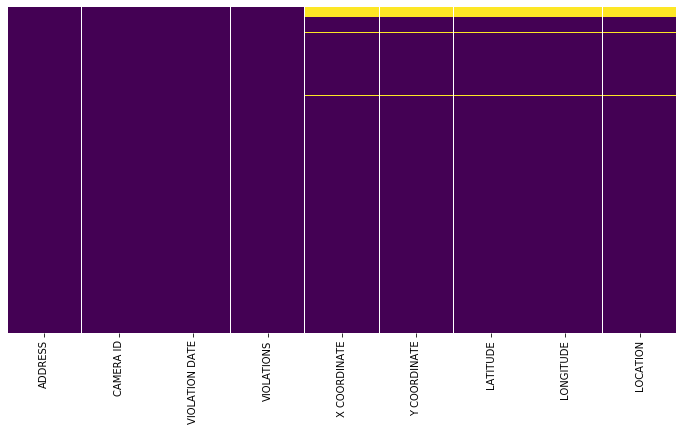

In [59]:
plt.figure(figsize=(12,6))
sns.heatmap(speed_camera.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [60]:
speed_camera.columns

Index(['ADDRESS', 'CAMERA ID', 'VIOLATION DATE', 'VIOLATIONS', 'X COORDINATE',
       'Y COORDINATE', 'LATITUDE', 'LONGITUDE', 'LOCATION'],
      dtype='object')

In [61]:
speed_camera['violation_date'] = pd.to_datetime(speed_camera['VIOLATION DATE'])
speed_camera2 = speed_camera[(speed_camera['violation_date'] > '2017-08-31') & 
                             (speed_camera['violation_date'] < '2020-03-01')]
speed_camera.drop('VIOLATION DATE', axis=1, inplace=True)

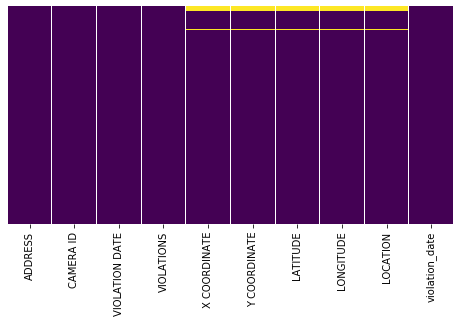

In [63]:
plt.figure(figsize=(8,4))
sns.heatmap(speed_camera2.isnull(), yticklabels=False, cbar=False, cmap='viridis');